# Lab 05 - Extended Exercises on Model Evaluation
## Predicting student performance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy as sp

# Data directory
DATA_DIR = "./../../data/"

In [2]:
# import requests

# exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

# npt_config = {
#     'session_name': 'lab-05',
#     'session_owner': 'mlbd',
#     'sender_name': input("Your name: "),
# }

## Introduction
The data has already been cleaned and it comes from 29 students in 3 different groups in a course of 26 weeks.

You already used this data in week 03. 

In this lab you will explore different models to predict the quiz grade. 

In [3]:
# Load data
df= pd.read_csv(f'{DATA_DIR}grades_in_time.csv.gz')
df.head()

,student,week,studying_hours,group,quiz_grade
0,0,0,39.9,3,6.1
1,0,1,32.4,3,7.0
2,0,2,17.5,3,6.9
3,0,3,16.0,3,7.0
4,0,4,15.9,3,7.2


In [4]:
df.describe(include='all')

,student,week,studying_hours,group,quiz_grade
count,810.000000,810.000000,810.000000,810.000000,810.000000
mean,14.500000,13.000000,10.050617,1.933333,6.931975
std,8.660789,7.793693,8.270041,0.772199,1.336888
min,0.000000,0.000000,1.000000,1.000000,1.200000
25%,7.000000,6.000000,5.700000,1.000000,6.400000
50%,14.500000,13.000000,7.800000,2.000000,7.200000
75%,22.000000,20.000000,11.100000,3.000000,7.800000
max,29.000000,26.000000,64.000000,3.000000,10.100000


# Task 1: Predict the quiz grade using the studying hours and the group.
----------
### 1.1 Split the data. 80% to train and the rest to test. 


In [5]:
from sklearn.model_selection import train_test_split

# Split the data 80% to train and the rest to test
# We'll predict the quiz grade for a specific week using the studying hours and the group
# Index is student and week
y = df['quiz_grade']
X = df[['studying_hours', 'group']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.head()

,studying_hours,group
662,6.8,3
239,4.8,3
445,6.4,1
333,8.8,2
292,9.8,2


### 1.2 Preprocess the data
Recall that group is a categorical feature.

Hint: Use ColumnTransformer.

In [7]:
# Remember that group is a categorical feature
# Preprocess the data such that the categorical feature is encoded using one-hot encoding
# and the numerical feature is scaled using StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(), ['group']),
    ('numerical', StandardScaler(), ['studying_hours'])
])
preprocessor.fit_transform(X_train)


array([[ 0.        ,  0.        ,  1.        , -0.39853379],
       [ 0.        ,  0.        ,  1.        , -0.64238432],
       [ 1.        ,  0.        ,  0.        , -0.4473039 ],
       ...,
       [ 0.        ,  1.        ,  0.        , -0.04495053],
       [ 1.        ,  0.        ,  0.        , -1.09350779],
       [ 0.        ,  1.        ,  0.        , -0.4473039 ]])

In [8]:
X_train.head()

,studying_hours,group
662,6.8,3
239,4.8,3
445,6.4,1
333,8.8,2
292,9.8,2


### 1.3 Create a pipeline (including the preprocessing steps) to predict the quiz grade using the studying hours and the group.

1. Use the model ElasticNet for the regression task.
2. Calculate the mean sqaured error of the prediction. 


Hint: Integrate the ColumnTransformer as a pipeline step

In [9]:
# Create a pipeline to predict the quiz grade using the studying hours and the group
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
error = mean_squared_error(y_test, y_pred)
#send(f"Mean Squared Error = {error}", 13)
print(f"Mean Squared Error = {error}")

Mean Squared Error = 1.723069058409944


### 1.4 Compute the cross validation score

In [10]:
# Compute the cross validation score
from sklearn.model_selection import cross_val_score

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

cvscore = np.mean((-1)*cross_val_score(pipe, X, y, cv = 5, scoring = 'neg_mean_squared_error'))
print(cvscore)
#send(cvscore, 14)

1.819927679248823


In [12]:
# import cross_validate
from sklearn.model_selection import cross_validate

cross_validate(
    pipe,
    X,
    y,
    cv=5,
    scoring='neg_mean_squared_error',
)

{'fit_time': array([0.0034461 , 0.00319386, 0.00295305, 0.00270629, 0.0024519 ]),
 'score_time': array([0.00160503, 0.0021863 , 0.00173211, 0.00141883, 0.00136018]),
 'test_score': array([-1.15538399, -1.70046188, -3.36715175, -1.62436725, -1.25227353])}

In [13]:
cross_val_score(pipe, X, y, cv = 5, scoring = 'neg_mean_squared_error')

array([-1.15538399, -1.70046188, -3.36715175, -1.62436725, -1.25227353])

### 1.5 Does the score in 1.3 differ from the score in 1.4? Why? 

In [11]:
answer = " One is average over many folds, the other is just one fold"
#send(answer, 15) 

### 1.6 What is wrong with data split?

In [12]:
answer = """ Let's take a look at the test set, and see that the test set has for students the past and the future 
Notice that student 0 has week 2,7,10,23 in the test set
but has week 0,1,3,4,5 in the train set
So we use the data from the future for student to predict the past
"""
#send(answer, 16) 

In [18]:
# print the rows in df that are in the test set
df[df.index.isin(X_test.index)].sort_index().head()
# can also use 
# df.loc[X_test.index].sort_index().head()

,student,week,studying_hours,group,quiz_grade
2,0,2,17.5,3,6.9
7,0,7,10.4,3,7.4
10,0,10,7.7,3,7.4
23,0,23,1.5,3,6.7
29,1,2,23.7,3,7.0


In [20]:
df[df.index.isin(X_train.index)].sort_index().head()

,student,week,studying_hours,group,quiz_grade
0,0,0,39.9,3,6.1
1,0,1,32.4,3,7.0
3,0,3,16.0,3,7.0
4,0,4,15.9,3,7.2
5,0,5,12.6,3,7.3


## Task 2: Time Validation

### 2.1 Train with the first 25 weeks and predict week 26.

Hint: You may re-use your pipeline

In [14]:
# We'll use the first 25 weeks of data for each student to predict the quiz grade of the 26th week
X_train = df[df['week'] <= 25][['studying_hours', 'group']]
y_train = df[df['week'] <= 25]['quiz_grade']

X_test = df[df['week'] == 26][['studying_hours', 'group']]
y_test = df[df['week'] == 26]['quiz_grade']

In [15]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
error = mean_squared_error(y_test, y_pred)
#send(f"Mean Squared Error = {error}", 21)
print(f"Mean Squared Error = {error}")

Mean Squared Error = 1.6729590540078738


### 2.2 Time splits
Would the model also be able to predict week 16 from all the previous weeks? 

What about week 5 from the previous weeks?

Create all the data splits so that the model predicts the next week given the information from the previous weeks. 

You may start taking the first 4 weeks to predict the 5th, then taking the first 5 weeks to predict the 6th, etc.


In [16]:
df[df['week'] == 4][['studying_hours', 'group']].head()

,studying_hours,group
4,15.9,3
31,23.1,3
58,6.7,2
85,4.8,2
112,3.1,1


In [17]:
# Create all the data splits so that the model predicts the next week given the information from the previous weeks
# You may start taking the first 4 weeks to predict the 5th, then taking the first 5 weeks to predict the 6th, etc.
# This will be fed to the cross validation function as the cv parameter
# Which expects a list of tuples (x_train_index, y_train_index)
time_splits = [
    (
        df[df['week'] <= week-1][['studying_hours', 'group']].index,
        df[df['week'] == week]['quiz_grade'].index
    )
    for week in range(5, 26)
]

In [18]:
time_splits[0][1]

Int64Index([  5,  32,  59,  86, 113, 140, 167, 194, 221, 248, 275, 302, 329,
            356, 383, 410, 437, 464, 491, 518, 545, 572, 599, 626, 653, 680,
            707, 734, 761, 788],
           dtype='int64')

In [19]:
time_splits[0][0]

Int64Index([  0,   1,   2,   3,   4,  27,  28,  29,  30,  31,
            ...
            756, 757, 758, 759, 760, 783, 784, 785, 786, 787],
           dtype='int64', length=150)

In [19]:
print(len(time_splits)) # 21 weeks
print(len(time_splits[0])) # x_train, y_train
print(time_splits[0][0].shape) # x_train
print(time_splits[0][1].shape) # y_train

21
2
(150,)
(30,)


### 2.3 Using the previously created splits, calculate the cross validation score

Hint: You may pass the splits with the parameter cv to the cross vadation function

In [20]:
errors = (-1)*cross_val_score(pipe, X, y, cv = time_splits, scoring = 'neg_mean_squared_error')
cvscore = np.mean(errors)
print(cvscore)
#send(cvscore, 23)

1.734621704107163


In [24]:
print(errors)
len(errors) # 21 weeks

[2.15221843 2.01598971 1.95714596 1.9228452  1.68057016 1.74331581
 1.59032267 1.57230925 1.72369407 1.57340757 1.62470424 1.56917964
 1.73223795 1.74502537 1.70382636 1.62030767 1.86304256 1.78514131
 1.73029424 1.53272073 1.58875686]


21

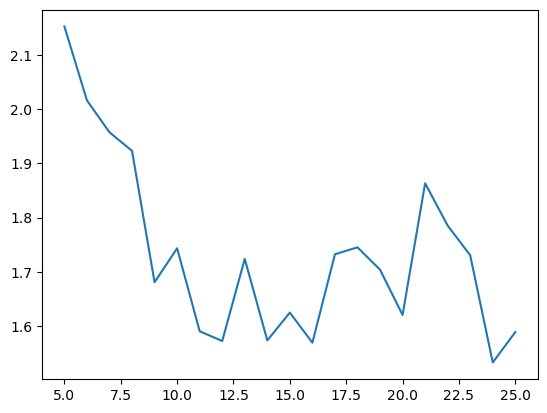

In [21]:
# Plot the error for each fold/week
plt.plot(range(5, 26), errors)

### 2.4 How does the error differ from the error of 2.1? Why?

In [23]:
answer = " Missing answer "
send(answer, 24) 

<Response [200]>

## Task 3: Nested cross-validation

Now imagine we want to optimize the hyperparameters for the model.

We will "ignore" time for now and take the mean studying hours and quiz grade. 


In [25]:
df_agg = df.groupby('student').mean()

X = df_agg[['studying_hours', 'group']]
y = df_agg['quiz_grade']

### 3.1 Gridsearch with cross validation

ElasticNet has two interesting parameters: alpha and l1_ratio.

Run a GridSearch to explore the following values:
* alpha = 0.1 and 1
* l1_ratio = 0.1, 0.5 and 1

What is the best score (smallest error)? 

In [26]:
# Grid search to find best params of ElasticNet
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

param_grid = {
    'model__alpha': [0.1, 1],
    'model__l1_ratio': [0.1, 0.5, 1]
},
search = GridSearchCV(
    pipe,
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error'
)
search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['group']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['studying_hours'])])),
                                       ('model', ElasticNet())]),
             param_grid=({'model__alpha': [0.1, 1],
                          'model__l1_ratio': [0.1, 0.5, 1]},),
             scoring='neg_mean_squared_error')

In [27]:
(-1)*search.best_score_

0.3115584609815575

In [28]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002839,0.000258,0.001510,0.000134,0.1,0.1,"{'model__alpha': 0.1, 'model__l1_ratio': 0.1}",-0.285957,-0.324098,-0.748826,-0.204564,-0.075939,-0.327877,0.227002,5
1,0.002441,0.000199,0.001285,0.000137,0.1,0.5,"{'model__alpha': 0.1, 'model__l1_ratio': 0.5}",-0.263225,-0.351905,-0.766026,-0.221290,-0.067521,-0.333994,0.234815,6
2,0.002283,0.000198,0.001289,0.000174,0.1,1,"{'model__alpha': 0.1, 'model__l1_ratio': 1}",-0.237618,-0.358420,-0.724531,-0.210438,-0.067295,-0.319660,0.222608,4
3,0.002330,0.000363,0.001240,0.000198,1,0.1,"{'model__alpha': 1, 'model__l1_ratio': 0.1}",-0.227664,-0.358420,-0.714337,-0.210438,-0.067295,-0.315631,0.219669,3
4,0.002547,0.000189,0.001447,0.000226,1,0.5,"{'model__alpha': 1, 'model__l1_ratio': 0.5}",-0.217099,-0.358420,-0.704541,-0.210438,-0.067295,-0.311558,0.216999,1
5,0.002452,0.000355,0.001316,0.000199,1,1,"{'model__alpha': 1, 'model__l1_ratio': 1}",-0.217099,-0.358420,-0.704541,-0.210438,-0.067295,-0.311558,0.216999,1


### 3.2 Why is the error from the best model in 3.1 biased?


In [27]:
answer = " Missing answer "
send(answer, 32) 

<Response [200]>

### 3.3 Improve 3.1 to have an unbiased estimation of the generalization error

Hint: Use nested cross-validation

In [29]:
from sklearn.model_selection import KFold
# The best model from 3.1 is biased because the grid search for the best parameters is done on the same data as the cross validation, i.e. we search for hyper-parameters on the test set.
# We can improve this by using nested cross-validation
# outer-fold: split the data into train and test
# inner-fold: split the train data into train and validation
# We use the test data to evaluate the model with the best hyper-parameters
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

param_grid = {
    'model__alpha': [0.1, 1],
    'model__l1_ratio': [0.1, 0.5, 1]
},

search = GridSearchCV(
    pipe,
    param_grid = param_grid,
    cv = inner_cv,
    scoring = 'neg_mean_squared_error'
)

errors = (-1)*cross_val_score(search, X, y, cv = outer_cv, scoring = 'neg_mean_squared_error')
print(errors.mean())

0.26757785377188387


In [38]:
search_aybars = GridSearchCV(
    pipe,
    param_grid = param_grid,
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
    scoring = 'neg_mean_squared_error'
)

all_models = []
all_errors = []

for train_index, test_index in outer_cv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Find best hyper parameters
    clf = search_aybars.fit(X_train, y_train)
    all_models.append(clf)

    # Evaluate the model with the best hyper parameters
    y_pred = clf.predict(X_test)

    all_errors.append(mean_squared_error(y_test, y_pred))

print(np.mean(all_errors))


0.26757785377188387


In [46]:
pd.DataFrame(all_models[0].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001861,0.000042,0.001041,0.000073,0.1,0.1,"{'model__alpha': 0.1, 'model__l1_ratio': 0.1}",-0.093415,-0.364937,-0.281131,-0.066500,-0.430289,-0.247254,0.144801,1
1,0.001833,0.000071,0.001017,0.000027,0.1,0.5,"{'model__alpha': 0.1, 'model__l1_ratio': 0.5}",-0.124058,-0.392910,-0.265535,-0.085260,-0.392356,-0.252024,0.129545,2
2,0.001840,0.000080,0.001029,0.000034,0.1,1,"{'model__alpha': 0.1, 'model__l1_ratio': 1}",-0.141000,-0.423214,-0.266597,-0.112446,-0.373750,-0.263401,0.122879,6
3,0.001896,0.000113,0.001067,0.000051,1,0.1,"{'model__alpha': 1, 'model__l1_ratio': 0.1}",-0.140973,-0.423214,-0.265594,-0.112446,-0.368513,-0.262148,0.121952,5
4,0.001846,0.000057,0.001056,0.000063,1,0.5,"{'model__alpha': 1, 'model__l1_ratio': 0.5}",-0.140944,-0.423214,-0.264489,-0.112446,-0.367373,-0.261693,0.121754,3
5,0.001809,0.000048,0.001017,0.000026,1,1,"{'model__alpha': 1, 'model__l1_ratio': 1}",-0.140944,-0.423214,-0.264489,-0.112446,-0.367373,-0.261693,0.121754,3
